In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj, sigmax, sigmaz, tensor, destroy, qeye, basis, fidelity
from scipy.optimize import minimize
from matplotlib.ticker import MaxNLocator
import qutip as qp

In [2]:
# Define parameters
omega_0 = 1  # cavity frequency (ω_0)
Omega = 1  # qubit frequency (Ω)
lambda_val = 0.2 # coupling strength (λ)
tru = 50  # Hilbert space dimension for cavity mode
tau = 0.02  # Fixed time step for evolution
steps=100
shots=1

In [3]:
# Cavity mode operator
a = tensor(destroy(tru), qeye(2))

# atom operators
sz = tensor(qeye(tru), sigmaz()) 
sx = tensor(qeye(tru), sigmax())  

# The Rabi model Hamiltonian
H1 = omega_0 * a.dag() * a  
H2 = (Omega / 2) * sz  
H3 = lambda_val * (a.dag() + a) * sx  
H = H1 + H2 + H3  

In [4]:
op=H

fidelities_origin = []
eigenvalues_1, _ = np.linalg.eig(H1)
eigenvalues_2, _ = np.linalg.eig(H2)
eigenvalues_3, _ = np.linalg.eig(H3)

c1 = max(eigenvalues_1)
c2 = max(eigenvalues_2)
c3 = max(eigenvalues_3)

k = c1 + c2 + c3
    
# Probabilities for random selection
p1 = c1 / k
p2 = c2 / k
p3 = c3 / k
ps=[p1,p2,p3]

# Normalized Hamiltonians
H1_norm = H1 / c1
H2_norm = H2 / c2
H3_norm = H3 / c3
Hs=[H1_norm,H2_norm,H3_norm]
    
    
#initial_state=tensor(basis(tru,5), basis(2, 0))
initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
rho = initial_state*initial_state.dag() 
exact_state=initial_state

for j in range(steps):

    exact_state = (-1j * H * tau).expm()*exact_state # evolution of exact statae
    rho_exact = exact_state*exact_state.dag()
    
    # evolution of random state in channel formula 
    rhos=[]
    for i in range(3):
        rhos.append(ps[i]*(-1j * Hs[i] * tau*k).expm() * rho * (1j * Hs[i] * tau*k).expm())
    rho=sum(rhos)
    
    # Calculate fidelity
    fidelity_origin = fidelity(rho,rho_exact)
    fidelities_origin.append(fidelity_origin)

In [5]:
op=H

fidelities_ew = []
c1 = 0.1
c2 = 0.1
c3 = 0.1

k = c1 + c2 + c3
    
# Probabilities for random selection
p1 = c1 / k
p2 = c2 / k
p3 = c3 / k
ps=[p1,p2,p3]

# Normalized Hamiltonians
H1_norm = H1 / c1
H2_norm = H2 / c2
H3_norm = H3 / c3
Hs=[H1_norm,H2_norm,H3_norm]
    
    
#initial_state=tensor(basis(tru,5), basis(2, 0))
initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
rho = initial_state*initial_state.dag() 
exact_state=initial_state

for j in range(steps):

    exact_state = (-1j * H * tau).expm()*exact_state # evolution of exact statae
    rho_exact = exact_state*exact_state.dag()
    
    # evolution of random state in channel formula 
    rhos=[]
    for i in range(3):
        rhos.append(ps[i]*(-1j * Hs[i] * tau*k).expm() * rho * (1j * Hs[i] * tau*k).expm())
    rho=sum(rhos)
    
    # Calculate fidelity
    fidelity_ew = fidelity(rho,rho_exact)
    fidelities_ew.append(fidelity_ew)

In [6]:
terms=[]
terms.append(H1)
terms.append(H2)
terms.append(H3)

In [7]:
def D_ij(H_i, H_j, rho):
    a = 1j * (H_j * rho - rho * H_j)
    b = 1j * (H_i * a - a * H_i)
    return b

In [8]:
dt = 0.001

In [9]:
def D(H, rho, error_list):
    T1 = qp.expect(H,rho) + error_list[0]
    T2 = qp.expect(H * H,rho) + error_list[1]
    result = np.sqrt(abs(2*T2 - 2*T1**2))
    return result

In [10]:
p1_list=[]
p2_list=[]
p3_list=[]

In [11]:
def Fidelity(steps, tau, shots):
    
    Fidelity_list = []
    
    initial_state=(tensor(basis(tru,5), basis(2, 0))+tensor(basis(tru,2), basis(2, 0)))/np.sqrt(2)
    rho_initial = initial_state*initial_state.dag() 
    exact_state=initial_state
    
    rho_steps_list = steps * [0]
    for i in range(shots):
        print(i)
        rho = rho_initial
        for j in range(steps):
            a = [0] * 2
            b = [0] * 2
            c = [0] * 2
            for k in range(2):
                a[k] = np.random.normal(loc=0, scale=0.1)
                b[k] = np.random.normal(loc=0, scale=0.1)
                c[k] = np.random.normal(loc=0, scale=0.1)
            
            D11 = D(terms[0], rho, a)
            D22 = D(terms[1], rho, b)
            D33 = D(terms[2], rho, c)
            
            Dsum=D11+D22+D33
            p1=D11/Dsum
            p2=D22/Dsum
            p3=D33/Dsum
            ps = [p1,p2,p3]
            
            p1_list.append(ps[0])
            p2_list.append(ps[1])
            p3_list.append(ps[2])
            
            rand= np.random.rand()
            if rand < ps[0]:
                rho = (-1j * H1 * tau/p1).expm() * rho * (1j * H1 * tau/p1).expm()
            elif rand < ps[0] + ps[1]:
                rho = (-1j * H2 * tau/p2).expm() * rho * (1j * H2 * tau/p2).expm()
            else:
                rho = (-1j * H3 * tau/p3).expm() * rho * (1j * H3 * tau/p3).expm()
            rho_steps_list[j] += rho / shots

    for i in range(steps):
        
        rho_exact = exact_state*exact_state.dag()
        
        Fidelity = fidelity(rho_steps_list[i],rho_exact)
        Fidelity_list.append(Fidelity)
        
        exact_state = (-1j * H * tau).expm()*exact_state
    
    return Fidelity_list

In [12]:
Fidelity_list = Fidelity(steps, tau, shots)

0


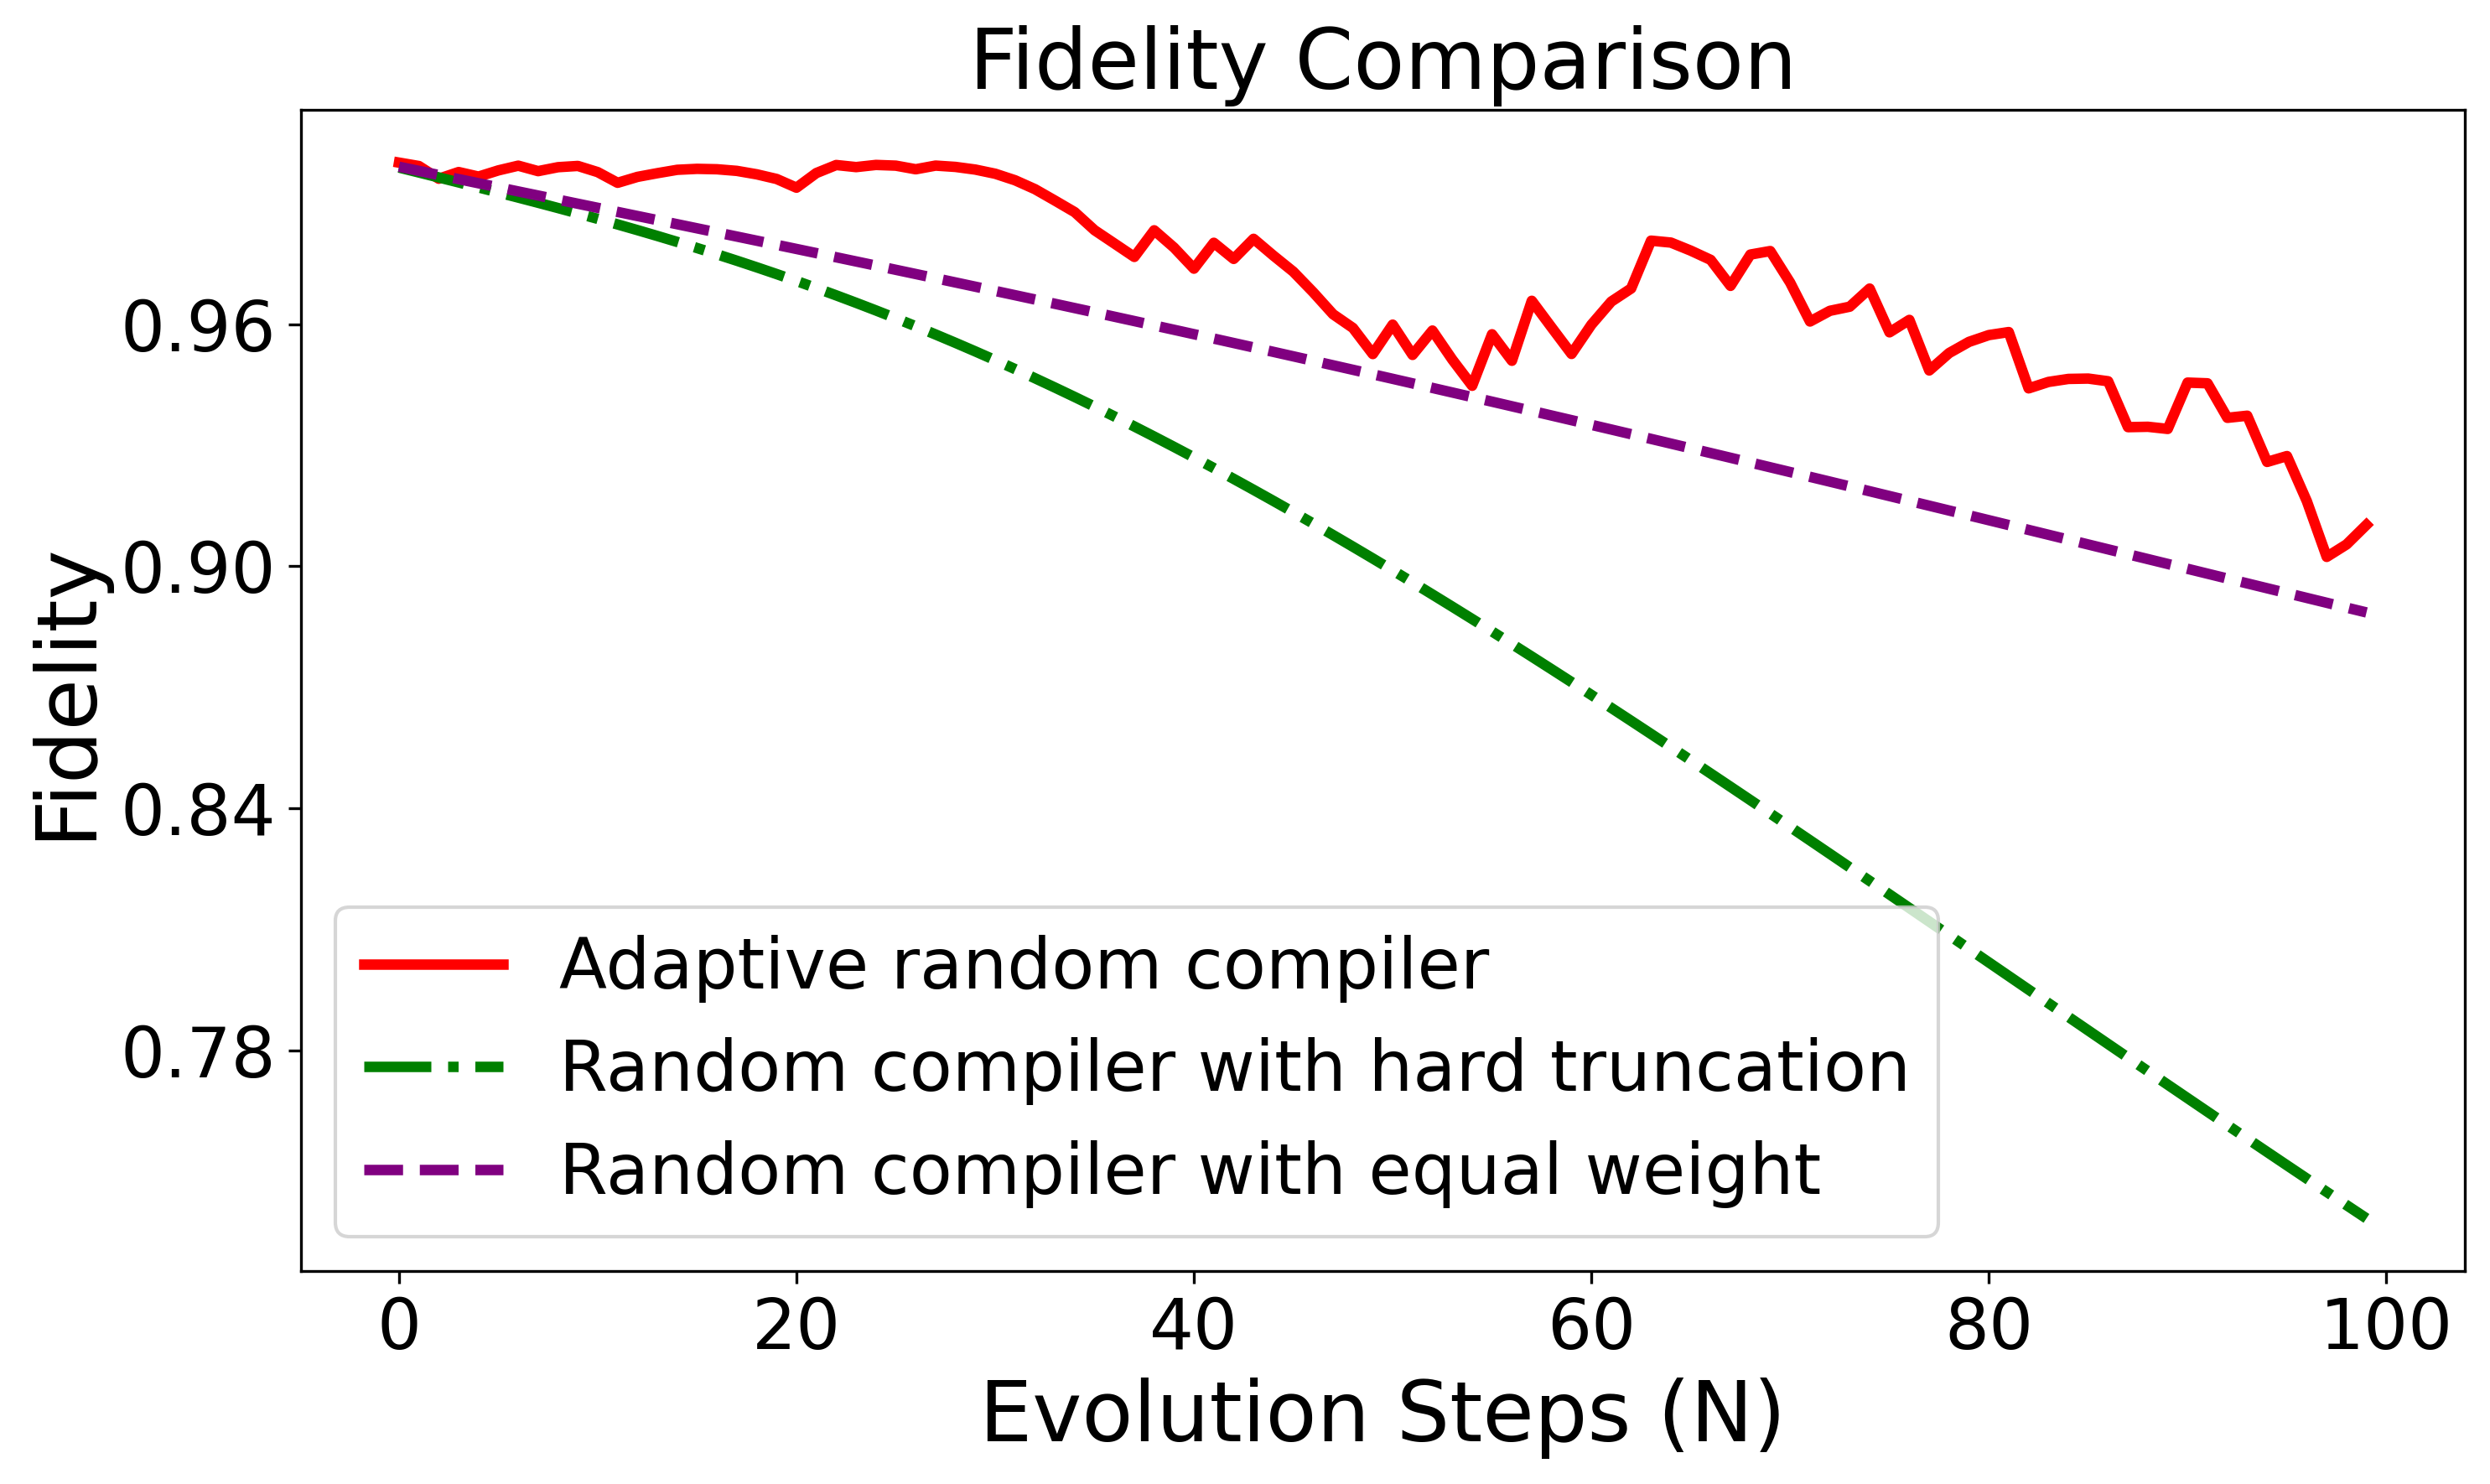

In [13]:
plt.figure(figsize=(10, 6), dpi=300)
    # Plot Fidelity for this beta value
plt.plot(range(steps), Fidelity_list, label=f'Adaptive random compiler', color='red', linewidth=3)
plt.plot(range(steps), fidelities_origin, label=f'Random compiler with hard truncation', color='green', linestyle='-.', linewidth=3)
plt.plot(range(steps), fidelities_ew, label=f'Random compiler with equal weight', color='purple', linestyle='--', linewidth=3)
plt.xlabel("Evolution Steps (N)", fontsize=24)
plt.ylabel("Fidelity", fontsize=24)
plt.title("Fidelity Comparison", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

ax = plt.gca()  # 获取当前坐标轴
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
plt.show()

In [14]:
print(Fidelity_list)

[1.0000000074505804, 0.9991582319573313, 0.9960074261124324, 0.9976637033571412, 0.996538204500834, 0.9980752366365461, 0.9992438234742533, 0.9978904301049397, 0.9988656305332289, 0.9991754534712077, 0.9976434374600693, 0.9949979588566455, 0.9964674102041448, 0.9973822029891813, 0.9982200442804041, 0.9984580740550701, 0.9983556197109658, 0.9979541116417234, 0.9971021953036959, 0.995950434194504, 0.9937851557540331, 0.9974157241640554, 0.9994057595511814, 0.9988909551019883, 0.9994276418316603, 0.9992493471822856, 0.9983543835422369, 0.9992618141512495, 0.9989362679631457, 0.9982759407971665, 0.9972473790952258, 0.9956258028103986, 0.993424938770614, 0.9906104338771738, 0.9877330167962277, 0.9832539472220218, 0.9799523488525704, 0.9766348097598704, 0.9832314632973003, 0.978939542603968, 0.9737288147584365, 0.9801380309557693, 0.9761421679710325, 0.9811255769733186, 0.9769558888905541, 0.9729792422296345, 0.9678914439401002, 0.9624373908647742, 0.9590369321991519, 0.9525696276647867, 0.9

In [15]:
print(fidelities_origin)

[0.9987790563766495, 0.9975570653184148, 0.996330591540087, 0.9950984397130828, 0.9938582567823459, 0.992606554949861, 0.9913401242508767, 0.9900556662720106, 0.9887498365459011, 0.9874225906761116, 0.9860679729826286, 0.9846859670679157, 0.9832734378564677, 0.9818296247575321, 0.9803510306697583, 0.9788356599179202, 0.9772841296418465, 0.9756948768498488, 0.9740619783416672, 0.9723898298079898, 0.9706742299822527, 0.9689161374206839, 0.9671123686419837, 0.9652657716003977, 0.9633724637409955, 0.9614354878414636, 0.9594508949631274, 0.9574200267262487, 0.9553456378611316, 0.9532242940276313, 0.9510576875618845, 0.9488439461833681, 0.9465858006903598, 0.944282712557508, 0.941936302631504, 0.93954562423438, 0.9371129107303712, 0.9346363274309284, 0.9321191527558778, 0.9295593457955343, 0.9269597911161154, 0.9243213996977867, 0.9216462114846069, 0.9189335049255418, 0.9161832268853574, 0.9133987726701528, 0.9105811949746773, 0.9077283681582109, 0.9048434380812032, 0.9019286762586457, 0.898

In [16]:
print(fidelities_ew)

[0.9989767663423613, 0.9979538187700959, 0.9969316223887427, 0.9959121168658158, 0.9948920600448085, 0.9938760688368792, 0.992859042398068, 0.9918435780851698, 0.9908287758402775, 0.9898145625554045, 0.9888013196104595, 0.9877845942783218, 0.9867703855783854, 0.9857544269468662, 0.9847401907000887, 0.9837207602619795, 0.982701266724583, 0.9816809059183859, 0.9806589126180918, 0.9796344668653275, 0.9786095587264017, 0.9775800707165421, 0.9765485757425499, 0.9755161862710596, 0.9744819464764711, 0.9734433244321515, 0.9724023329535757, 0.9713570870015028, 0.9703110354288099, 0.9692607093043949, 0.9682075520833746, 0.9671517398426864, 0.9660917542756573, 0.965029122871125, 0.9639627251871254, 0.9628938949907564, 0.9618200475609334, 0.9607443075832907, 0.9596631609841919, 0.9585804577913976, 0.9574933763868388, 0.9564020923673365, 0.9553077774581145, 0.9542114305583673, 0.9531117836984102, 0.9520067663416268, 0.9508986959766905, 0.9497864490979449, 0.9486710185974424, 0.9475544889872576, 0.

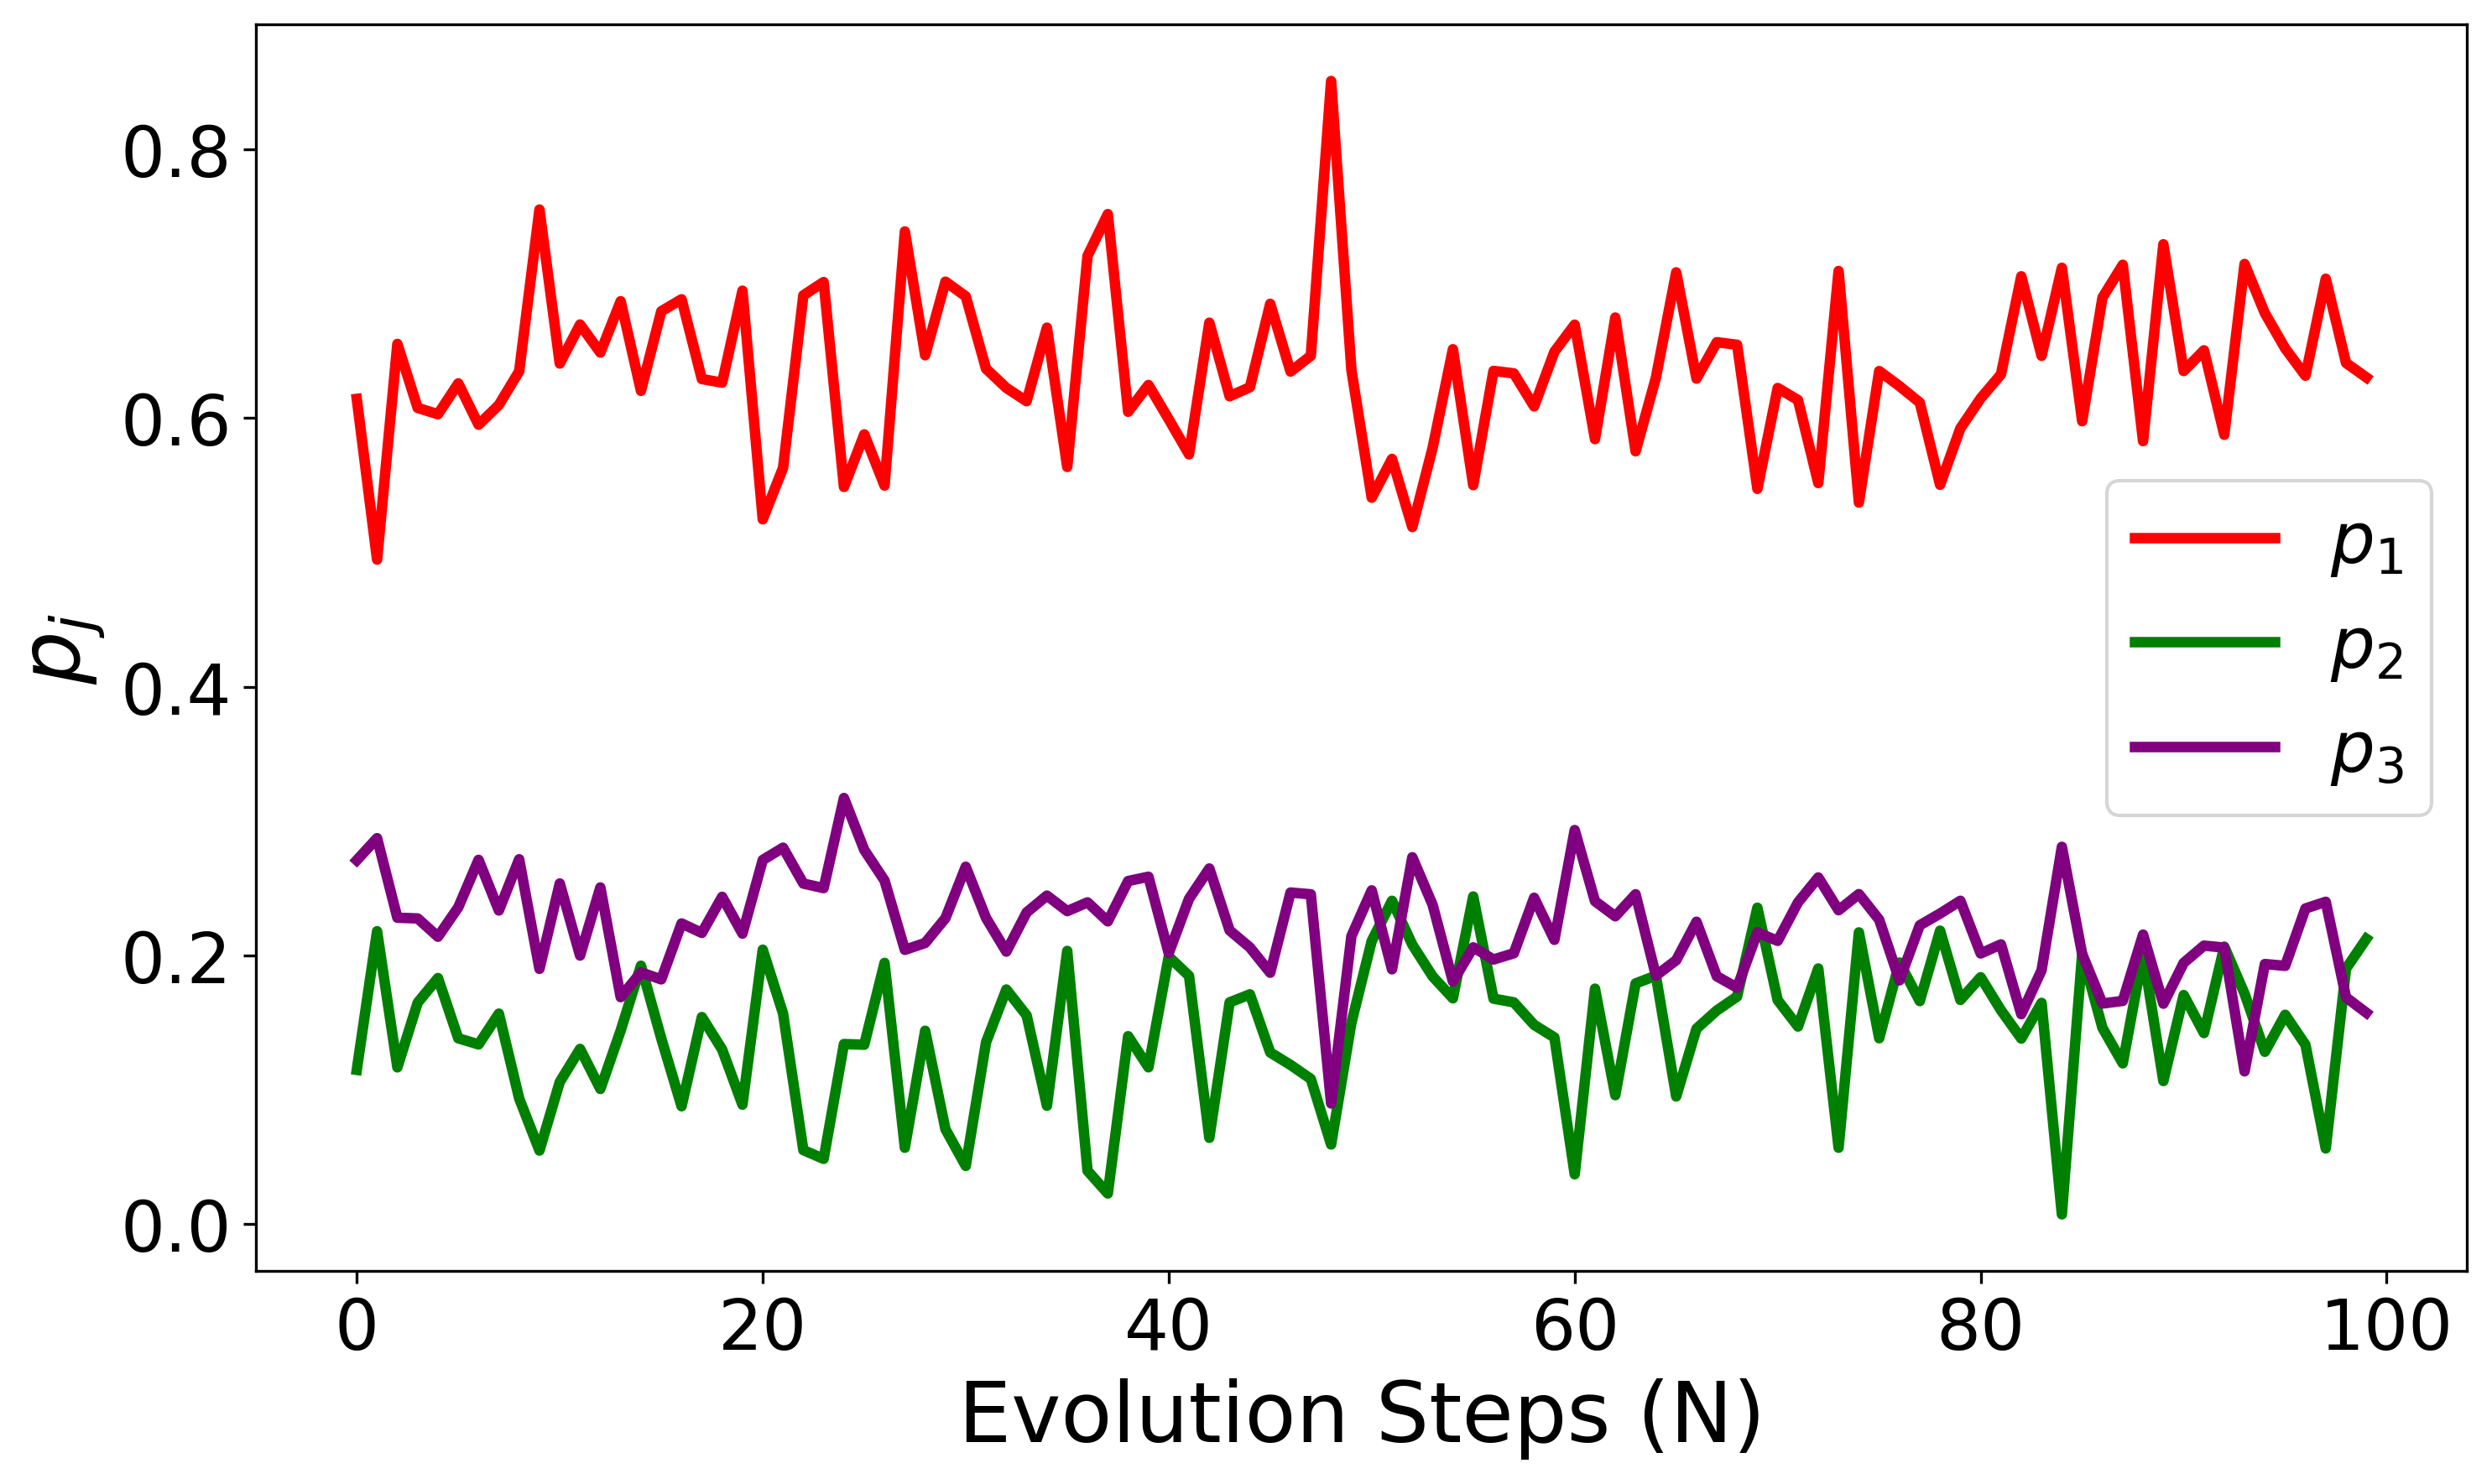

In [17]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(range(steps), p1_list, label=r"${p}_{1}$", color='red', linestyle='-', linewidth=3)
plt.plot(range(steps), p2_list, label=r"${p}_{2}$", color='green', linestyle='-', linewidth=3)
plt.plot(range(steps), p3_list, label=r"${p}_{3}$", color='purple', linestyle='-', linewidth=3)
plt.xlabel("Evolution Steps (N)", fontsize=24)
plt.ylabel(r"$p_{j}$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

ax = plt.gca()  # 获取当前坐标轴
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
plt.show()

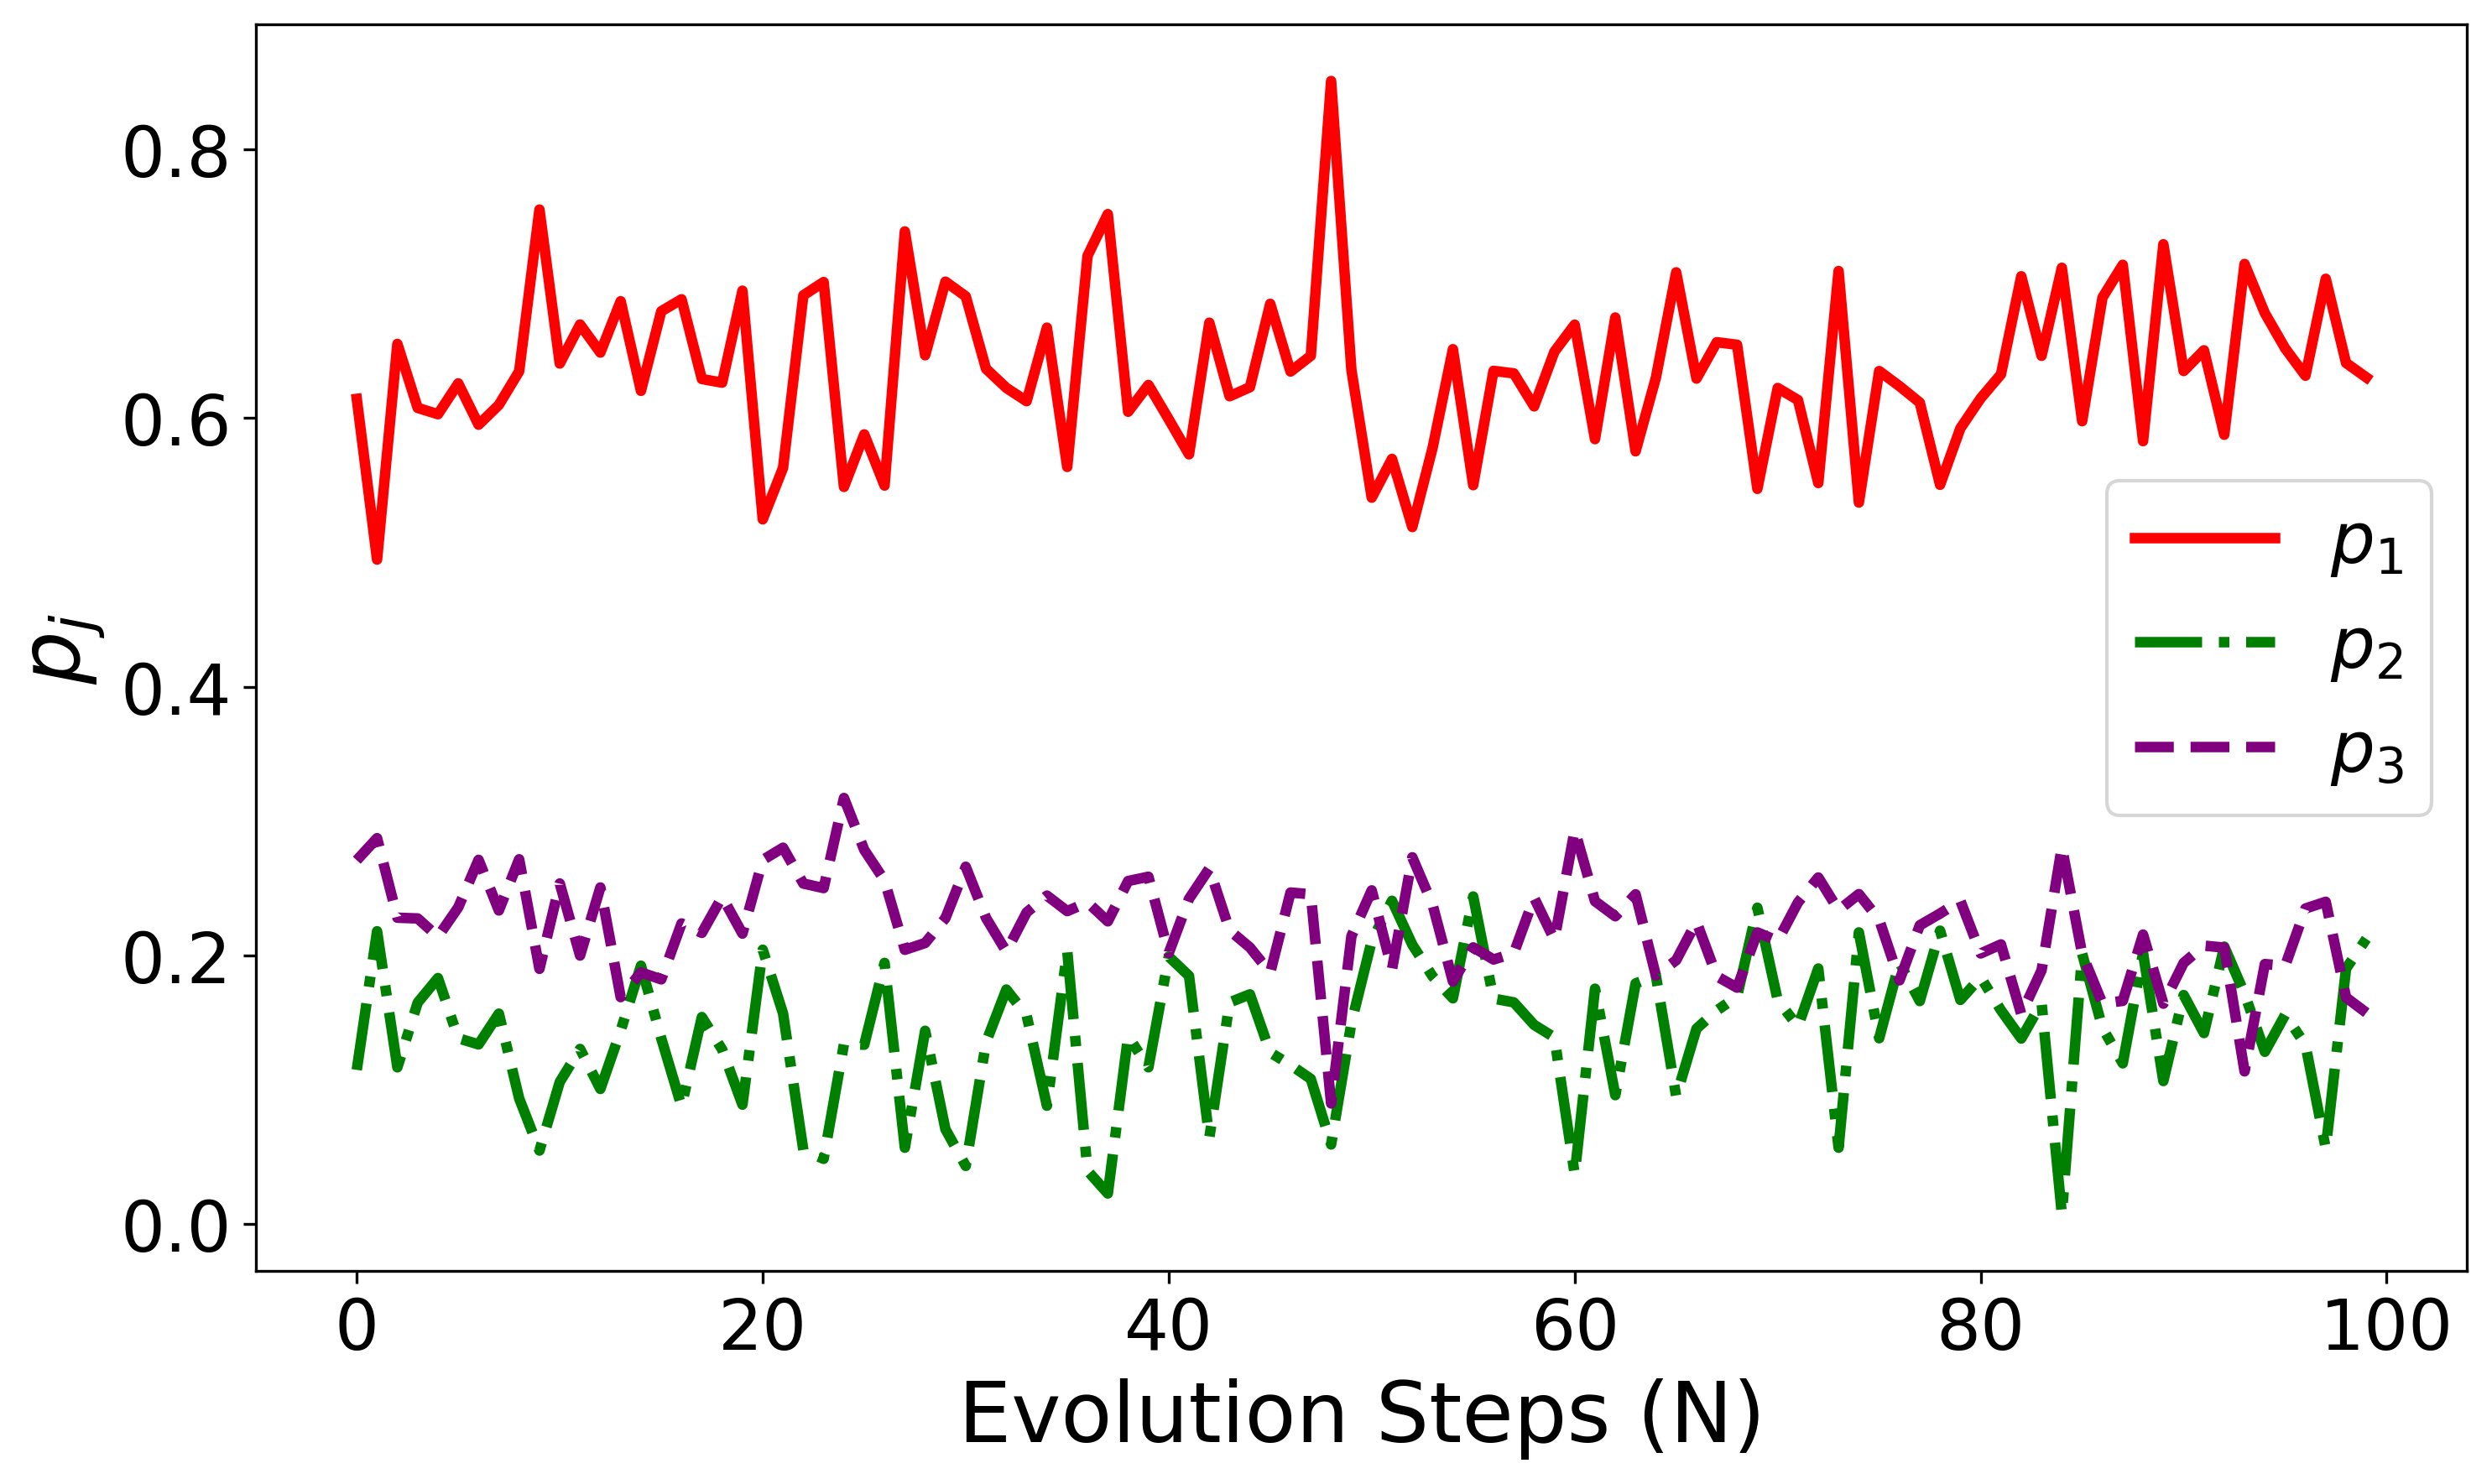

In [18]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(range(steps), p1_list, label=r"${p}_{1}$", color='red', linestyle='-', linewidth=3)
plt.plot(range(steps), p2_list, label=r"${p}_{2}$", color='green', linestyle='-.', linewidth=3)
plt.plot(range(steps), p3_list, label=r"${p}_{3}$", color='purple', linestyle='--', linewidth=3)
plt.xlabel("Evolution Steps (N)", fontsize=24)
plt.ylabel(r"$p_{j}$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

ax = plt.gca()  # 获取当前坐标轴
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
plt.show()

In [19]:
p1_list

[0.6143340192778379,
 0.49469816791796534,
 0.6552717078992749,
 0.607633477705074,
 0.6029316560352708,
 0.625873694422597,
 0.5950900224771865,
 0.6098502244069246,
 0.6348742587806394,
 0.7552977656178259,
 0.6406510892497809,
 0.6697066848100801,
 0.648810487887197,
 0.6870483424992547,
 0.6203126487828167,
 0.6795695682885555,
 0.6884992449974704,
 0.629122964375084,
 0.6264109315806093,
 0.6948968990403476,
 0.5246688919117676,
 0.5630012679936421,
 0.6914399331091388,
 0.7013429123815343,
 0.5487811564615824,
 0.587910030989607,
 0.5498110839832316,
 0.739009969682785,
 0.6468284189150698,
 0.7016293284596191,
 0.6906896302038876,
 0.6367856584686371,
 0.6225423397291245,
 0.612610668381125,
 0.6673751037193244,
 0.5636796565723422,
 0.7208216877034771,
 0.7519105642880766,
 0.6047577783341156,
 0.6247088862246416,
 0.5991767226914814,
 0.5730525766882435,
 0.6710664523650289,
 0.6163088537075576,
 0.6230423873211578,
 0.6851368380778851,
 0.6346801194790308,
 0.6464366089516164

In [20]:
p2_list

[0.11479662450426296,
 0.21800598064134372,
 0.1166616132905367,
 0.1648278122981043,
 0.1831578634759811,
 0.1383090962981578,
 0.13374478918636504,
 0.1566810883936443,
 0.09353242494916206,
 0.054717255846122324,
 0.1057735901111297,
 0.13039248122485267,
 0.10058571084339282,
 0.14401468390997954,
 0.1923482491662637,
 0.1382555651031907,
 0.08769956771688099,
 0.15412271317767298,
 0.12994262628826994,
 0.08888384948869388,
 0.2042642869917205,
 0.15678949836969058,
 0.055044511336281285,
 0.048545842496236176,
 0.13401265345951602,
 0.13351846931114486,
 0.19444133888462492,
 0.056825562393822644,
 0.14391386936793224,
 0.07061844629912403,
 0.04329670599789309,
 0.13531064207886032,
 0.17462641515148428,
 0.15535730629788752,
 0.08808842943500059,
 0.2033449734111395,
 0.03967442838186027,
 0.022741920624384314,
 0.13986054228247646,
 0.1166922106723668,
 0.1991543535601928,
 0.18478077235286325,
 0.06419847186544199,
 0.16504406946370648,
 0.17102661210493664,
 0.12774828628453

In [21]:
p3_list

[0.27086935621789915,
 0.287295851440691,
 0.2280666788101883,
 0.22753870999682171,
 0.21391048048874817,
 0.23581720927924518,
 0.2711651883364485,
 0.23346868719943112,
 0.27159331627019856,
 0.18998497853605176,
 0.25357532063908944,
 0.19990083396506717,
 0.2506038012694101,
 0.16893697359076568,
 0.1873391020509196,
 0.18217486660825374,
 0.22380118728564863,
 0.21675432244724316,
 0.24364644213112072,
 0.21621925147095852,
 0.271066821096512,
 0.2802092336366672,
 0.25351555555458005,
 0.2501112451222295,
 0.31720619007890155,
 0.27857149969924805,
 0.25574757713214347,
 0.20416446792339232,
 0.20925771171699803,
 0.22775222524125685,
 0.26601366379821934,
 0.2279036994525027,
 0.20283124511939118,
 0.23203202532098746,
 0.2445364668456751,
 0.23297537001651822,
 0.23950388391466265,
 0.22534751508753897,
 0.25538167938340794,
 0.25859890310299166,
 0.2016689237483259,
 0.2421666509588932,
 0.26473507576952915,
 0.21864707682873585,
 0.2059310005739056,
 0.18711487563758056,
 0.